In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fraud-detection-dataset-csv/Fraud Detection Dataset.csv


In [2]:
# libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [3]:
# loading and info, head
fraud_data = pd.read_csv('/kaggle/input/fraud-detection-dataset-csv/Fraud Detection Dataset.csv')

fraud_data.info()
fraud_data.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51000 entries, 0 to 50999
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Transaction_ID                    51000 non-null  object 
 1   User_ID                           51000 non-null  int64  
 2   Transaction_Amount                48480 non-null  float64
 3   Transaction_Type                  51000 non-null  object 
 4   Time_of_Transaction               48448 non-null  float64
 5   Device_Used                       48527 non-null  object 
 6   Location                          48453 non-null  object 
 7   Previous_Fraudulent_Transactions  51000 non-null  int64  
 8   Account_Age                       51000 non-null  int64  
 9   Number_of_Transactions_Last_24H   51000 non-null  int64  
 10  Payment_Method                    48531 non-null  object 
 11  Fraudulent                        51000 non-null  int64  
dtypes: f

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Time_of_Transaction,Device_Used,Location,Previous_Fraudulent_Transactions,Account_Age,Number_of_Transactions_Last_24H,Payment_Method,Fraudulent
50995,T33982,2339,3112.51,Bill Payment,15.0,Mobile,New York,0,7,8,Debit Card,0
50996,T31261,2152,2897.15,Online Purchase,3.0,Mobile,Miami,1,75,11,Net Banking,1
50997,T12293,3345,2204.43,POS Payment,18.0,Mobile,San Francisco,3,73,5,Credit Card,0
50998,T42287,1518,4787.17,POS Payment,19.0,Tablet,New York,2,108,14,Net Banking,0
50999,T13665,2315,814.72,POS Payment,3.0,Tablet,Los Angeles,0,50,10,Invalid Method,0


In [4]:
# null and duplicated
fraud_data.isnull().sum()
fraud_data.duplicated().sum()

np.int64(881)

In [5]:
# mathematics states
fraud_data.describe()

,User_ID,Transaction_Amount,Time_of_Transaction,Previous_Fraudulent_Transactions,Account_Age,Number_of_Transactions_Last_24H,Fraudulent
count,51000.000000,48480.000000,48448.000000,51000.000000,51000.000000,51000.000000,51000.000000
mean,3005.110176,2996.249784,11.488400,1.995725,60.033902,7.495588,0.049216
std,1153.121107,5043.932555,6.922954,1.415150,34.384131,4.020080,0.216320
min,1000.000000,5.030000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,2007.000000,1270.552500,5.000000,1.000000,30.000000,4.000000,0.000000
50%,2996.000000,2524.100000,12.000000,2.000000,60.000000,7.000000,0.000000
75%,4006.000000,3787.240000,17.000000,3.000000,90.000000,11.000000,0.000000
max,4999.000000,49997.800000,23.000000,4.000000,119.000000,14.000000,1.000000


In [6]:
# no. of fraud
col = ['Location','Device_Used', 'Payment_Method']
print(fraud_data['Fraudulent'].value_counts())
for col in fraud_data.columns.difference(['Transaction_ID', 'User_ID', 'Fraudulent']):
    print(pd.crosstab(fraud_data[col],fraud_data['Fraudulent'], normalize='columns')*100)


Fraudulent
0    48490
1     2510
Name: count, dtype: int64
Fraudulent          0         1
Account_Age                    
1            0.874407  0.836653
2            0.890905  1.155378
3            0.845535  1.155378
4            0.833161  0.796813
5            0.855847  0.557769
...               ...       ...
115          0.864096  0.517928
116          0.810476  0.637450
117          0.812539  0.876494
118          0.845535  0.996016
119          0.864096  0.916335

[119 rows x 2 columns]
Fraudulent              0          1
Device_Used                         
Desktop         32.591133  31.721798
Mobile          32.073469  34.181510
Tablet          32.183933  30.916031
Unknown Device   3.151465   3.180662
Fraudulent             0          1
Location                           
Boston         12.675292  12.987013
Chicago        12.453871  13.992459
Houston        12.479920  11.813992
Los Angeles    12.377893  12.987013
Miami          12.358355  12.484290
New York       12.634047  1

# 1) Device: 34.18% chance fraud is done by mobile, and 66% mobile or desktop and unknown device is the lowest
# 2) Amount: The highest fraud amount is 49,997.80 (32 cases), while the lowest is 14.31 with a single occurrence.
# 3) Location: Chicago has the highest fraud count (334), followed by Boston and Los Angeles (310 each), with Seattle showing the lowest.
# 4) Transaction Type: Online purchases are the most fraud-prone, whereas ATM withdrawals have the lowest fraud occurrence.
# 5) Previous Fraud: Users with a prior fraud history are significantly more likely to commit fraud, accounting for 519 cases.
# 6) Account Age: Accounts under 100 days old contribute to 83% of total fraud, highlighting higher risk in new accounts.
# 7) Frequency: 72% of fraud occurs within fewer than 10 transactions in 24 hours, with noticeable spikes at 6 and 12 transactions.
# 8) Payment Method: UPI has the highest fraud cases (612), followed by credit cards and net banking (574), while invalid methods are least risky.
# 10) Time: Fraud activity is higher around hours 15, 20, and 22, indicating peak-risk time windows.

# **summery** 
# *Fraudesters are repeated offenders operating through newly created accounts, primarly using  mobile and desktop to make online purchases via UPI around 3 pm,  frequently executing high-value transactions (49,997.8) with burst activity of about 6 transactions within the last 24 hours* 


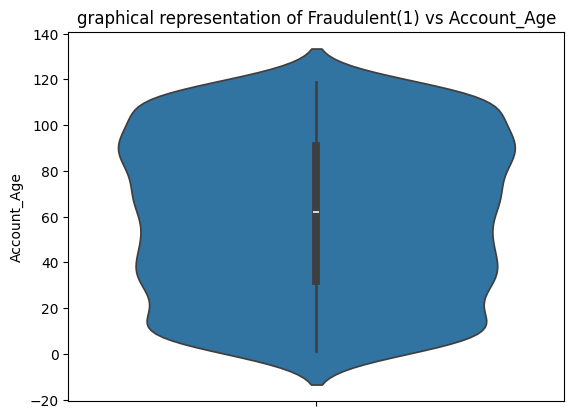

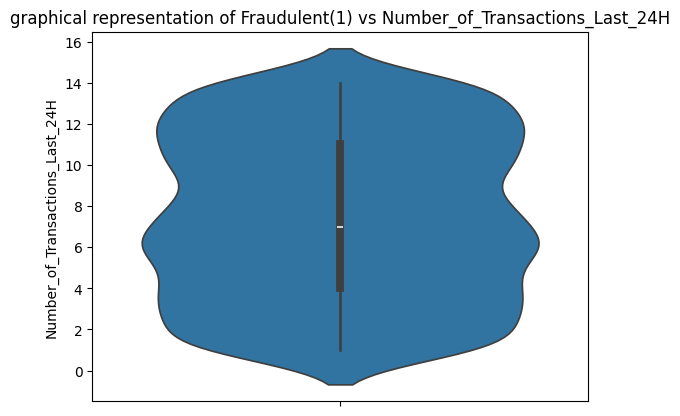

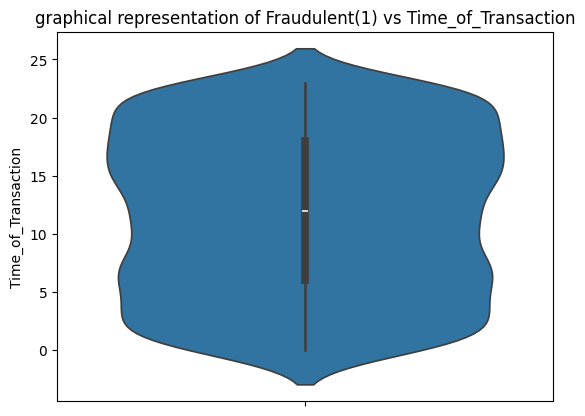

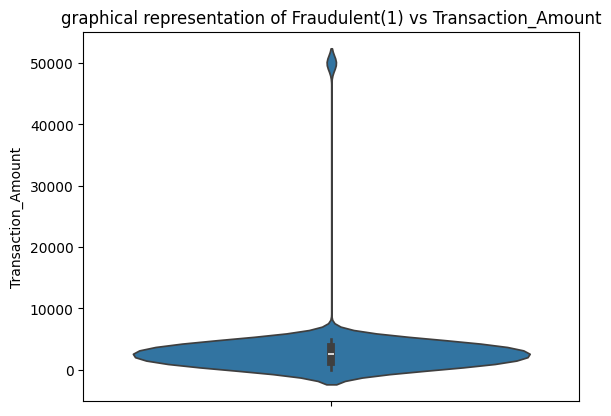

In [7]:
# graphical representation numerical 
fraud = fraud_data[fraud_data['Fraudulent']==1]
for col in fraud.select_dtypes(include=np.number).columns.difference(['Fraudulent','User_ID', 'Previous_Fraudulent_Transactions']):
    sns.violinplot(data=fraud, y=col)
    plt.title(f'graphical representation of Fraudulent(1) vs {col}')
    plt.ylabel(col)
    plt.show()

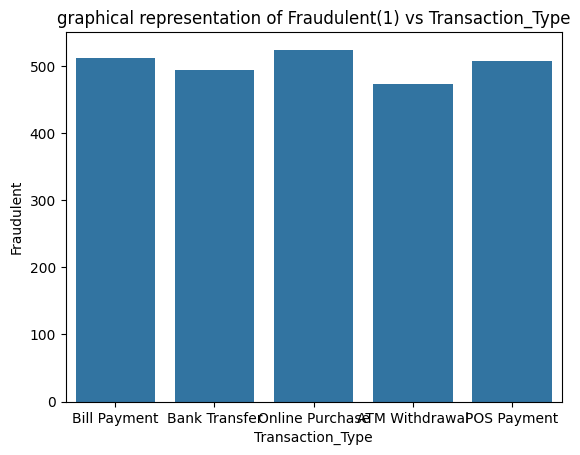

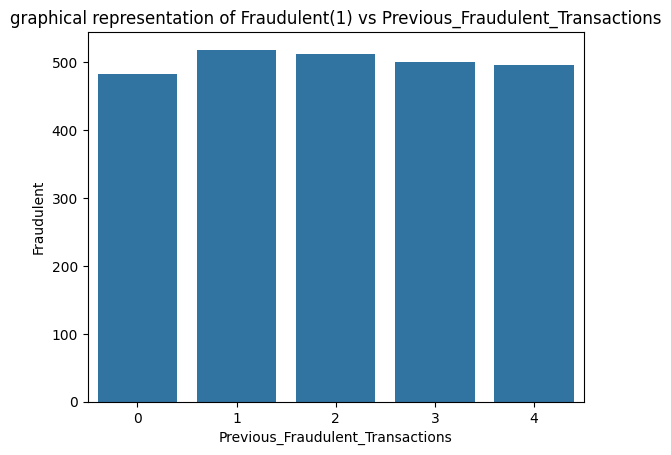

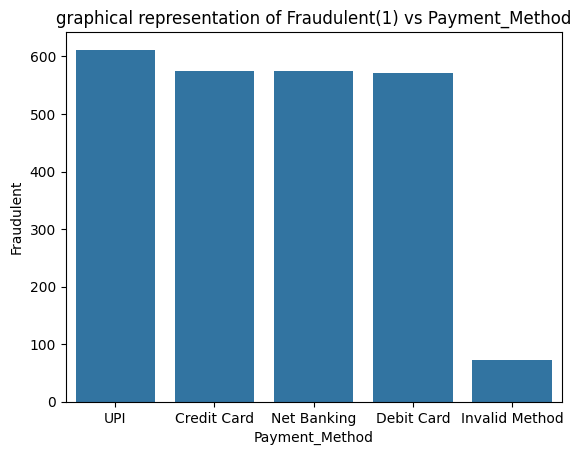

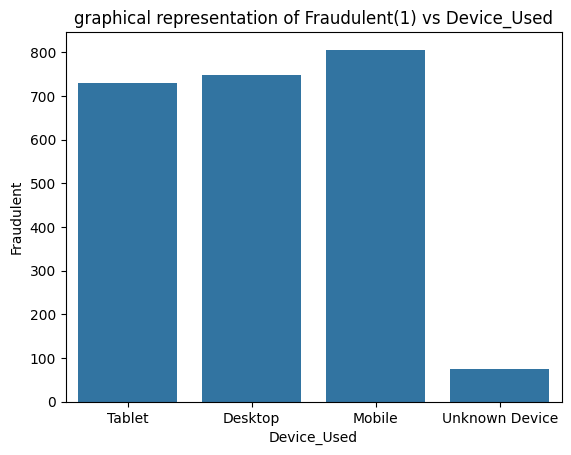

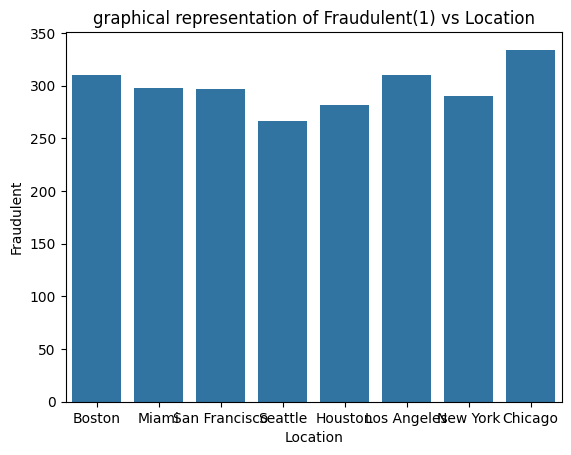

In [8]:
# graphical representation of categorical 
fraud = fraud_data[fraud_data['Fraudulent']==1]
colum = fraud.select_dtypes(include='object').columns.tolist() +['Previous_Fraudulent_Transactions']
for col in set(colum)-{'Transaction_ID'}:
    sns.countplot(data=fraud, x=col)
    plt.title(f'graphical representation of Fraudulent(1) vs {col}')
    plt.xlabel(col)
    plt.ylabel('Fraudulent')
    plt.show()

In [9]:
pd.crosstab([fraud_data['Location'], fraud_data['Transaction_Type']],fraud_data['Fraudulent'],normalize='index')*100

Fraudulent                              0         1
Location      Transaction_Type                     
Boston        ATM Withdrawal    95.440252  4.559748
              Bank Transfer     94.707298  5.292702
              Bill Payment      95.245902  4.754098
              Online Purchase   94.621849  5.378151
              POS Payment       94.754098  5.245902
Chicago       ATM Withdrawal    94.912427  5.087573
              Bank Transfer     95.570139  4.429861
              Bill Payment      93.589744  6.410256
              Online Purchase   93.551020  6.448980
              POS Payment       94.915254  5.084746
Houston       ATM Withdrawal    95.230263  4.769737
              Bank Transfer     95.850285  4.149715
              Bill Payment      94.966443  5.033557
              Online Purchase   95.819113  4.180887
              POS Payment       94.762684  5.237316
Los Angeles   ATM Withdrawal    95.465995  4.534005
              Bank Transfer     93.885760  6.114240
              Bill Payment      94.947875  5.052125
              Online Purchase   94.533221  5.466779
              POS Payment       95.446585  4.553415
Miami         ATM Withdrawal    95.286195  4.713805
              Bank Transfer     94.330320  5.669680
              Bill Payment      95.695364  4.304636
              Online Purchase   94.402036  5.597964
              POS Payment       95.412844  4.587156
New York      ATM Withdrawal    95.652174  4.347826
              Bank Transfer     95.864351  4.135649
              Bill Payment      95.020080  4.979920
              Online Purchase   94.601128  5.398872
              POS Payment       95.159967  4.840033
San Francisco ATM Withdrawal    94.837635  5.162365
              Bank Transfer     95.098039  4.901961
              Bill Payment      95.090016  4.909984
              Online Purchase   95.146444  4.853556
              POS Payment       95.020080  4.979920
Seattle       ATM Withdrawal    95.881384  4.118616
              Bank Transfer     95.893720  4.106280
              Bill Payment      95.592949  4.407051
              Online Purchase   96.237458  3.762542
              POS Payment       94.601329  5.398671

In [10]:
pd.crosstab([ fraud_data['Previous_Fraudulent_Transactions'], fraud_data['Account_Age']],fraud_data['Fraudulent'],normalize='index')*100

Fraudulent                                            0          1
Previous_Fraudulent_Transactions Account_Age                      
0                                1            96.551724   3.448276
                                 2            96.907216   3.092784
                                 3            89.583333  10.416667
                                 4            93.750000   6.250000
                                 5            98.823529   1.176471
...                                                 ...        ...
4                                115          97.674419   2.325581
                                 116          94.897959   5.102041
                                 117          96.551724   3.448276
                                 118          96.103896   3.896104
                                 119          91.836735   8.163265

[595 rows x 2 columns]

In [11]:
pd.crosstab([ fraud_data['Previous_Fraudulent_Transactions'], fraud_data['Transaction_Amount']],fraud_data['Fraudulent'],normalize='index')*100

Fraudulent                                                    0         1
Previous_Fraudulent_Transactions Transaction_Amount                      
0                                5.03                100.000000  0.000000
                                 5.04                100.000000  0.000000
                                 5.76                100.000000  0.000000
                                 5.90                100.000000  0.000000
                                 5.97                100.000000  0.000000
...                                                         ...       ...
4                                4998.95             100.000000  0.000000
                                 4999.09             100.000000  0.000000
                                 4999.16             100.000000  0.000000
                                 4999.78             100.000000  0.000000
                                 49997.80             95.698925  4.301075

[46548 rows x 2 columns]

In [12]:
time_bucket = pd.cut(fraud_data['Time_of_Transaction'], bins=[0,10,14,19,24], labels=['morning','evening','afternoon','night'])
age_bucket = pd.cut(fraud_data['Account_Age'], bins=[0,10,30,100,240], labels=['new','young','mid','old'])
amount_bucket = pd.cut(fraud_data['Transaction_Amount'], bins=[0,80,900,1500,5000,100000], labels=['very small','small','moderate','high','very high'])
trans_bucket = pd.qcut(fraud_data['Number_of_Transactions_Last_24H'], q=4, labels=['single','low','mid','high'])

In [13]:
pd.crosstab([ fraud_data['Time_of_Transaction'], fraud_data['Number_of_Transactions_Last_24H']],fraud_data['Fraudulent'],normalize='index')*100

Fraudulent                                                   0         1
Time_of_Transaction Number_of_Transactions_Last_24H                     
0.0                 1                                94.303797  5.696203
                    2                                94.202899  5.797101
                    3                                95.833333  4.166667
                    4                                97.241379  2.758621
                    5                                96.710526  3.289474
...                                                        ...       ...
23.0                10                               95.934959  4.065041
                    11                               92.857143  7.142857
                    12                               90.476190  9.523810
                    13                               97.902098  2.097902
                    14                               98.136646  1.863354

[336 rows x 2 columns]

In [14]:
pd.crosstab([fraud_data['Device_Used'], fraud_data['Payment_Method']], fraud_data['Fraudulent'],normalize='index')*100

Fraudulent                             0         1
Device_Used    Payment_Method                     
Desktop        Credit Card     95.547108  4.452892
               Debit Card      95.262588  4.737412
               Invalid Method  96.000000  4.000000
               Net Banking     94.866008  5.133992
               UPI             95.296071  4.703929
Mobile         Credit Card     94.697390  5.302610
               Debit Card      94.678183  5.321817
               Invalid Method  95.555556  4.444444
               Net Banking     94.852532  5.147468
               UPI             94.770338  5.229662
Tablet         Credit Card     95.167824  4.832176
               Debit Card      95.418162  4.581838
               Invalid Method  93.932584  6.067416
               Net Banking     95.580878  4.419122
               UPI             95.044200  4.955800
Unknown Device Credit Card     94.721408  5.278592
               Debit Card      96.253602  3.746398
               Invalid Method  98.275862  1.724138
               Net Banking     93.732194  6.267806
               UPI             96.220930  3.779070

# **mulitvariant insides**
# top 2 are online purchases and bank transfer chicago and los angeles in main highly fraud and seattle both least an pos payment is top with loewst fraud due to both are least
# by overall number upi(top on tablet) is bigger, but top 2 positions debit card in higher fraud mobile and desktop and in unknown device 2nd lowest debit card
# new account (0 to 9 days) are top on not offenders, one and two time offenders, but 3 to 4 time offenders have mid(30 to 99) and old(+100) are top respectively
# 1 and 4 time offenders do very small(0 to 80) amount, but 0,2, and 3 time offender do very high (5000 to 100000) amount.
# morning, afternoon, and night have low(4 to 7) trangection, and evening have mid(7 to 11) trangection on last 24h.

In [15]:
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51000 entries, 0 to 50999
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Transaction_ID                    51000 non-null  object 
 1   User_ID                           51000 non-null  int64  
 2   Transaction_Amount                48480 non-null  float64
 3   Transaction_Type                  51000 non-null  object 
 4   Time_of_Transaction               48448 non-null  float64
 5   Device_Used                       48527 non-null  object 
 6   Location                          48453 non-null  object 
 7   Previous_Fraudulent_Transactions  51000 non-null  int64  
 8   Account_Age                       51000 non-null  int64  
 9   Number_of_Transactions_Last_24H   51000 non-null  int64  
 10  Payment_Method                    48531 non-null  object 
 11  Fraudulent                        51000 non-null  int64  
dtypes: f

# **Model Prepration**

In [16]:
# split the data
X = fraud_data[fraud_data.columns.difference(['Fraudulent', 'User_ID', 'Transaction_ID'])]
y = fraud_data['Fraudulent']
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2, random_state=42,stratify=y)

In [17]:
# fill numerical values
num_col=['Transaction_Amount','Time_of_Transaction']
for col in num_col:
    X_train[col]=X_train[col].fillna(X_train[col].median())
    X_test[col]=X_test[col].fillna(X_train[col].median())

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40800 entries, 35910 to 7994
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Account_Age                       40800 non-null  int64  
 1   Device_Used                       38828 non-null  object 
 2   Location                          38794 non-null  object 
 3   Number_of_Transactions_Last_24H   40800 non-null  int64  
 4   Payment_Method                    38833 non-null  object 
 5   Previous_Fraudulent_Transactions  40800 non-null  int64  
 6   Time_of_Transaction               40800 non-null  float64
 7   Transaction_Amount                40800 non-null  float64
 8   Transaction_Type                  40800 non-null  object 
dtypes: float64(2), int64(3), object(4)
memory usage: 3.1+ MB


In [18]:
# fill categorical values
cat_col = ['Device_Used', 'Location','Payment_Method']
for col in cat_col:
    X_train[col]=X_train[col].fillna(X_train[col].mode()[0])
    X_test[col]=X_test[col].fillna(X_train[col].mode()[0])

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40800 entries, 35910 to 7994
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Account_Age                       40800 non-null  int64  
 1   Device_Used                       40800 non-null  object 
 2   Location                          40800 non-null  object 
 3   Number_of_Transactions_Last_24H   40800 non-null  int64  
 4   Payment_Method                    40800 non-null  object 
 5   Previous_Fraudulent_Transactions  40800 non-null  int64  
 6   Time_of_Transaction               40800 non-null  float64
 7   Transaction_Amount                40800 non-null  float64
 8   Transaction_Type                  40800 non-null  object 
dtypes: float64(2), int64(3), object(4)
memory usage: 3.1+ MB


In [19]:
#  Train feature engineering
X_train['time_bucket'] = pd.cut(X_train['Time_of_Transaction'], bins=[0,10,14,19,24], labels=['morning','evening','afternoon','night'])
X_train['Age_bucket'] = pd.cut(X_train['Account_Age'], bins=[0,10,30,100,240], labels=['new','young','mid','old'])
X_train['Amount_backet'] = pd.cut(X_train['Transaction_Amount'], bins=[0,80,900,1500,5000,100000],labels=['very small', 'small', 'moderate', 'high', 'very high'])
X_train['Trans_bucket']= pd.cut(X_train['Number_of_Transactions_Last_24H'],bins=[0,4,7,11,14],labels=['single','low', 'mid', 'high'])

In [20]:
#  Test feature engineering
X_test['time_bucket'] = pd.cut(X_test['Time_of_Transaction'], bins=[0,10,14,19,24], labels=['morning','evening','afternoon','night'])
X_test['Age_bucket'] = pd.cut(X_test['Account_Age'], bins=[0,10,30,100,240], labels=['new','young','mid','old'])
X_test['Amount_backet'] = pd.cut(X_test['Transaction_Amount'], bins=[0,80,900,1500,5000,100000],labels=['very small', 'small', 'moderate', 'high', 'very high'])
X_test['Trans_bucket']= pd.cut(X_test['Number_of_Transactions_Last_24H'],bins=[0,4,7,11,14],labels=['single','low', 'mid', 'high'])

In [21]:
# Encoding
X_train_p = X_train.drop(columns=['Age_bucket', 'time_bucket', 'Trans_bucket', 'Amount_backet'])
X_test_p = X_test.drop(columns=['Age_bucket', 'time_bucket', 'Trans_bucket', 'Amount_backet'])
X_train_p.info()
X_test_p.info()
col = X_train_p.select_dtypes(include='object').columns
num_col = X_train.select_dtypes(include=np.number).columns
preprocessing = ColumnTransformer(transformers=[('num', StandardScaler(), num_col), ('cat', OneHotEncoder(handle_unknown='ignore',sparse_output=False), col)])
X_train_pre = preprocessing.fit_transform(X_train_p)
X_test_pre = preprocessing.transform(X_test_p)

<class 'pandas.core.frame.DataFrame'>
Index: 40800 entries, 35910 to 7994
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Account_Age                       40800 non-null  int64  
 1   Device_Used                       40800 non-null  object 
 2   Location                          40800 non-null  object 
 3   Number_of_Transactions_Last_24H   40800 non-null  int64  
 4   Payment_Method                    40800 non-null  object 
 5   Previous_Fraudulent_Transactions  40800 non-null  int64  
 6   Time_of_Transaction               40800 non-null  float64
 7   Transaction_Amount                40800 non-null  float64
 8   Transaction_Type                  40800 non-null  object 
dtypes: float64(2), int64(3), object(4)
memory usage: 3.1+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 10200 entries, 1515 to 46015
Data columns (total 9 columns):
 #   Column                      

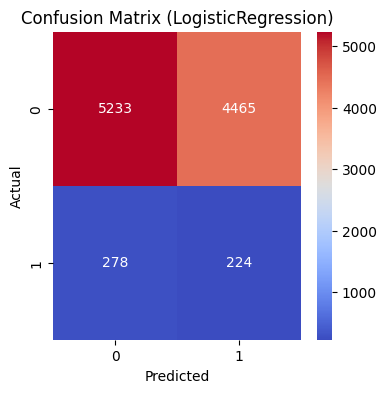

acuraccy: 0.535


In [22]:
lr = LogisticRegression(class_weight='balanced', random_state=42)
lr.fit(X_train_pre,y_train)
score=lr.score(X_test_pre,y_test)
y_pre_lr=lr.predict(X_test_pre)
y_preo_lr = lr.predict_proba(X_test_pre)[:, 1]
y_pred_lr = (y_preo_lr>0.5).astype(int)
cm = confusion_matrix(y_test,y_pred_lr)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d',cmap='coolwarm')
plt.title('Confusion Matrix (LogisticRegression)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(f'acuraccy: {score}')

In [23]:
from sklearn.metrics import roc_auc_score
y_preo = lr.predict_proba(X_test_pre)[:, 1]
print(f'Roc Auc Score:{roc_auc_score(y_test, y_preo)}')
print(classification_report(y_test, y_pred_lr))

Roc Auc Score:0.4920292022259487
              precision    recall  f1-score   support

           0       0.95      0.54      0.69      9698
           1       0.05      0.45      0.09       502

    accuracy                           0.54     10200
   macro avg       0.50      0.49      0.39     10200
weighted avg       0.91      0.53      0.66     10200



# **Logistic Regression with class balancing improves fraud sensitivity, its ROC-AUC (~0.49) indicates weak separation between fraud and non-fraud classes.At the tuned threshold, the model captures approximately 45% of fraud cases, but this comes with a high number of false alarms, leading to a drop in overall accuracy. Try Random Forest Model**

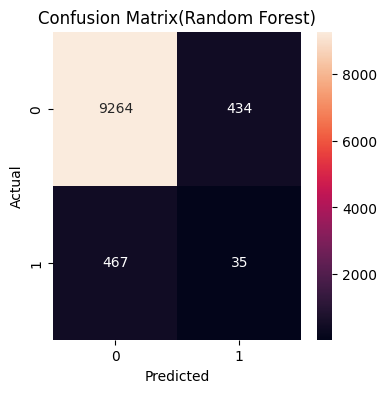

accuracy: 0.9116666666666666


In [24]:

rf = RandomForestClassifier(n_estimators=500, max_depth=10, min_samples_leaf=20, class_weight='balanced',random_state=42, n_jobs=-1)
rf.fit(X_train_pre,y_train)
y_pre = rf.predict(X_test_pre)
y_preo = rf.predict_proba(X_test_pre)[:, 1]
y_pred_rf = (y_preo>0.5).astype(int)
score=rf.score(X_test_pre,y_test)
# confusion matrix
cm = confusion_matrix(y_test,y_pred_rf)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix(Random Forest)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(f'accuracy: {score}')

In [25]:

y_preo = rf.predict_proba(X_test_pre)[:, 1]
print(f'Roc Auc Score:{roc_auc_score(y_test, y_preo)}')
print(classification_report(y_test, y_pred_rf))

Roc Auc Score:0.5085077302668066
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      9698
           1       0.07      0.07      0.07       502

    accuracy                           0.91     10200
   macro avg       0.51      0.51      0.51     10200
weighted avg       0.91      0.91      0.91     10200



# **The Random Forest model achieves high overall accuracy due to class imbalance, but at the default threshold(0.5) it detects very few fraud cases(7%). That's why see XGBoost**

In [26]:

xgb = XGBClassifier(n_estimators=300, max_depth=5, learning_rate=0.05,subsample=0.8, colsample_bytree=0.8, scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(), objective='binary:logistic', random_state=42, eval_metric='aucpr')
xgb.fit(X_train_pre, y_train)
y_preo_xgb = xgb.predict_proba(X_test_pre)[:, 1]
y_pred_xgb = (y_preo_xgb>0.4).astype(int)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.95      0.43      0.59      9698
           1       0.05      0.58      0.09       502

    accuracy                           0.44     10200
   macro avg       0.50      0.50      0.34     10200
weighted avg       0.91      0.44      0.57     10200



# **The XGBoost model with a tuned decision threshold of 0.4 captures approximately 58% of fraud cases while reducing false alarms compared to lower thresholds, making it a practical trade-off for real-world fraud detection where recall is prioritized over raw accuracy**